In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sns.plotting_context(context='paper')
sns.set_palette('rainbow')

import pandas as pd
import prophet

In [26]:
sales = pd.read_csv('../../../data/mckinsey/sales.csv', index_col='ID')

skus = pd.read_csv('../../../data/mckinsey/sku.csv', index_col='SKU')

geo_params = pd.read_csv('../../../data/mckinsey/geo_params.csv', index_col='geoCluster')

sales = sales.join(skus, on='SKU')
sales = sales.join(geo_params, on='geoCluster')

In [27]:
sales = sales.loc[sales['date'] >= '2020-04-01']
sales.fillna(1, inplace=True)

In [28]:
covid_response = pd.read_excel('../../../data/oxford/OxCGRT_timeseries_all.xlsx')
covid_response.head()

In [30]:
avg_covid_response = covid_response.select_dtypes('number').mean()
avg_covid_response.index = pd.to_datetime(avg_covid_response.index)

<AxesSubplot:>

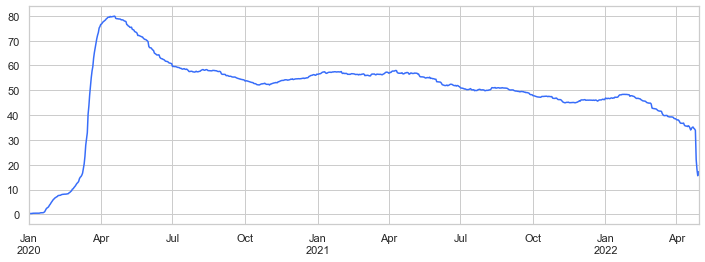

In [31]:
avg_covid_response.plot(figsize=(12, 4))

In [32]:
sales['date'] = pd.to_datetime(sales['date'])
sales.fillna(1, inplace=True)

daily_sales = sales.groupby('date')['sales'].sum()

<AxesSubplot:xlabel='date'>

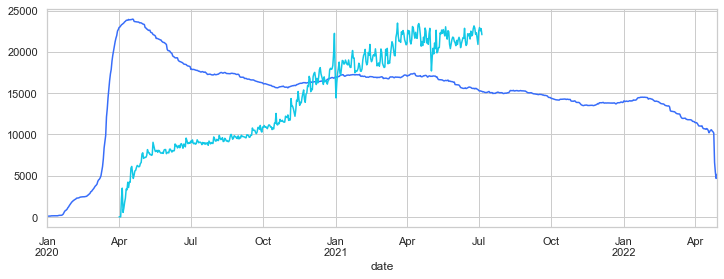

In [33]:
fig, ax = plt.subplots(figsize=(12, 4))

(avg_covid_response * 300).plot(ax=ax)
daily_sales.plot(ax=ax)

#### Add Covid stringency index as regressor for Prophet model

In [34]:
timeframe_of_interest = pd.date_range(start=sales['date'].min(), end=sales['date'].max())

In [35]:
sales_per_day = sales.groupby('date')['sales'].sum().reindex(timeframe_of_interest, fill_value=0)

In [36]:
additional_clusters_added = sales.groupby('geoCluster')['date'].min().reset_index().groupby('date')['geoCluster'].count()
geoclusters_cumsum = additional_clusters_added.reindex(timeframe_of_interest, fill_value=0).cumsum()

In [51]:
full_training_set = sales_per_day.reset_index().rename(columns={'index': 'ds', 'sales': 'y'})

full_training_set = full_training_set.join(geoclusters_cumsum.rename('active_geoclusters'), on='ds')
full_training_set = full_training_set.join(avg_covid_response.rename('covid_response'), on='ds')

full_training_set = full_training_set.sort_values(by='ds')

split_date = pd.to_datetime('2020-12-01')

training_set = full_training_set.loc[full_training_set['ds'] < split_date]
validation_set = full_training_set.loc[full_training_set['ds'] >= split_date]

In [52]:
m = prophet.Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
#m.add_regressor('active_geoclusters', mode='multiplicative')
m.add_regressor('covid_response', mode='multiplicative')
m.add_country_holidays(country_name='UK')
m.fit(training_set)

C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [53]:
prediction = m.predict(full_training_set.drop(columns='y'))

C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\prophet\forecaster.py:896: FutureWarning: The frame.append method i

Text(0, 0.5, 'Sales')

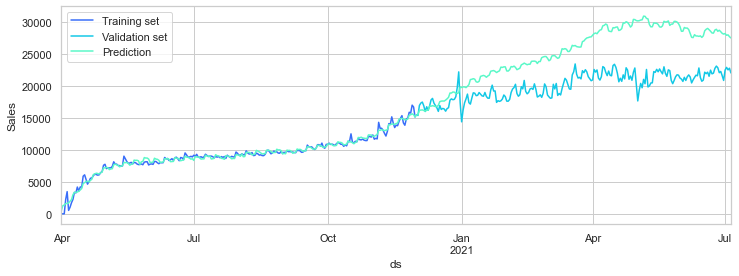

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))

training_set.plot(ax=ax, x='ds', y='y', label='Training set')
validation_set.plot(ax=ax, x='ds', y='y', label='Validation set')
prediction.plot(ax=ax, x='ds', y='yhat', label='Prediction')

ax.set_ylabel('Sales')

In [55]:
m.train_holiday_names

0                                        New Year's Day
1                           New Year Holiday [Scotland]
2                  St. Patrick's Day [Northern Ireland]
3                Battle of the Boyne [Northern Ireland]
4                        Summer Bank Holiday [Scotland]
5                           St. Andrew's Day [Scotland]
6                                         Christmas Day
7                                           Good Friday
8        Easter Monday [England/Wales/Northern Ireland]
9                                               May Day
10                                  Spring Bank Holiday
11    Late Summer Bank Holiday [England/Wales/Northe...
12                                           Boxing Day
13                                Boxing Day (Observed)
dtype: object